In this notebook we analyze satellite imagery of the Amazon basin to gain insights into the forest composition. We perform some exploratory data analysis, and pre-process the image data to convert to a format conducive for learning using neural networks.

We use the image data available at the [Kaggle site](https://www.kaggle.com/competitions/planet-understanding-the-amazon-from-space/data) for our analysis.

### Exploratory Data Analysis

#### Lets first import the required libraries

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

#### The data is available at the 'data/train-jpg' directory path.  Let's check the file names and the number of images available

In [2]:
! ls data/train-jpg/ | head

train_0.jpg
train_1.jpg
train_10.jpg
train_100.jpg
train_1000.jpg
train_10000.jpg
train_10001.jpg
train_10002.jpg
train_10003.jpg
train_10004.jpg
ls: write error: Broken pipe


In [3]:
! ls data/train-jpg/ | wc -l

40479


We see the image file names are of the format train_n.jpg, where n is a number, and there are 40,479 images available.

#### The 'train_v2.csv' file has the labels associated with each of these images, let's load the csv to a dataframe and inspect the data:

In [4]:
! ls data/train_v2.csv

data/train_v2.csv


In [5]:
df_target = pd.read_csv('data/train_v2.csv')
df_target.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
df_target.shape

(40479, 2)

We see that the dataset is a multi-labled dataset, wherein the images are tagged with multiple labels delimited by space. 

Let's check if the df_target dataframe contains any null values:

In [7]:
df_target.isnull().sum()

image_name    0
tags          0
dtype: int64

#### Let's view some of the images using the matplotlib library
* The images are accessed from the 'data/train-jp' path on the file system and the corresponding labels retrieved from the df_target dataframe. 
* In the image plots displayed below, the labels are depicted as titles for each of the images.

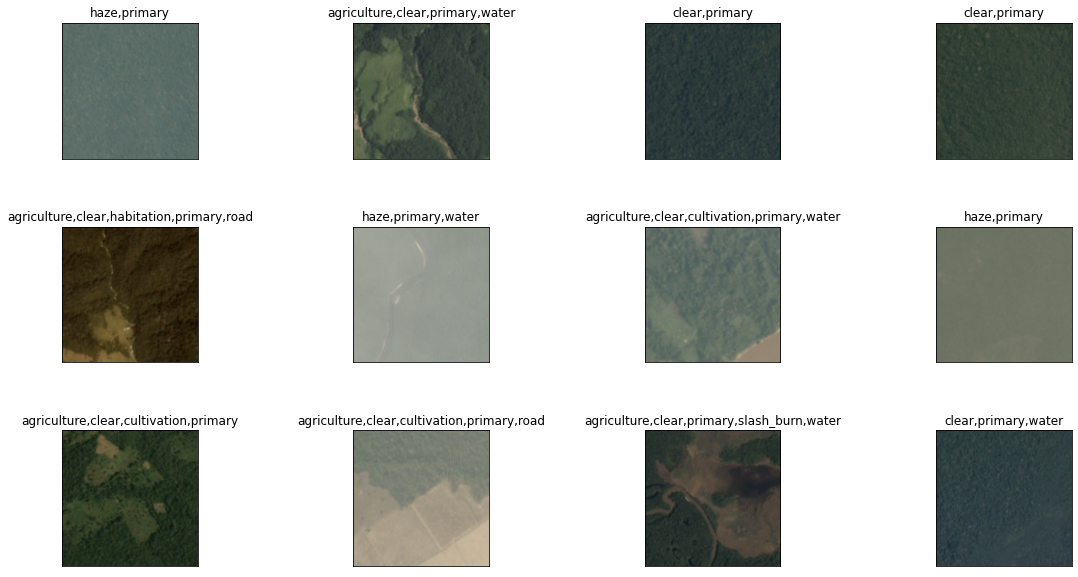

In [8]:
path_prfx = 'data/train-jpg/train_'
dlim = ','
ext = '.jpg'
fig = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.5)
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    img = imread(path_prfx + str(i) + ext)
    labels = dlim.join(df_target.iloc[i]['tags'].split())
    ax.title.set_text(labels)
    ax.imshow(img)

We see that the images are tagged with multiple labels depicting atmospheric cloud cover conditions such as haze, clear and/or land types such as primary, agriculture, water, road, slash_burn  etc.

We will look into the meaning of these labels shortly down the line.

#### Lets use the technique of one-hot encoding to create a separate column for each of the labels in the df_target dataframe

First, lets create a set with all the unique tags/labels

In [9]:
unique_tags = set()
for item in df_target['tags'].values:
    tags = item.split(' ')
    unique_tags.update(tags)

Next, define a function to create each label as a separate column of the dataframe and assign the value 1 if the image is tagged with the label, and 0 otherwise

In [10]:
def encode_tags(row, var1):
    '''
    INPUT:
    row (pd.Series) : row of the dataframe
    var1 (str) : label value to check for in the tags column
    
    OUTPUT:
    int : 1 if the tag contains the label, 0 otherwise
    
    Description:
    The function is used to create a new column in the df_target dataframe corresponding to each of the 
    unique labels present in the dataset.
    '''
    tag_values = row['tags'].split(' ')
    if var1 in tag_values:
        return 1
    else:
        return 0   

In [11]:
for tag in unique_tags:
    df_target[tag] = df_target.apply(encode_tags, var1=tag, axis=1)   

Lets create a list of all the label categories:

In [12]:
categories = list(df_target.select_dtypes(include='int64').columns)
categories.sort()

Display the sorted categories list:

In [13]:
display(categories)

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

As we can see there are 17 distinct categories or class labels. Some of the labels are related to cloud conditions such as cloudy, partly cloudy, haze etc. and some are related to the type of land such as primary, agriculture, habitation etc.

Below is a brief description of what some of these label mean:

* Cloudy images have 90% of the image obscured by cloud conditions
* Clear images have no evidence of cloud conditions
* Haze images have some cloud cover but are not so opaque so as to obscure the ground
* Primary images refer to the type of land covered by the primary rainforest
* Water images depict presence of water, river or lake
* Habitation images depict presence of human dwellings
* Bare_Ground refers to naturally occurring tree free areas that aren't the result of human activity.

Explanation of some other label terms:
* Slash_Burn refers to images which show patches of the forest slashed and burnt for agriculture.
* Conventional Mining refers to images that show large conventional mines.
* Artisinal Mining refers to images that depict small scale mining operations.
* Blow Down refers to a naturally occurring phenomenon in the Amazon where the cold dry air from the Andes mountain range settles on top of the warm moist air of the rainforest.
* Blooming refers to a natural phenomenon found in the Amazon where particular species of flowering trees bloom, fruit, and flower at the same time to maximize the chances of cross pollination.

A detailed explanation of all the labels is available on the [Kaggle site](https://www.kaggle.com/competitions/planet-understanding-the-amazon-from-space/data)

We will update the dataframe so that the category columns representing the label names appear in sorted order: 

In [14]:
noncat = list(df_target.select_dtypes(include='object').columns)

In [15]:
df_target = df_target.loc[:, noncat+categories]

In [16]:
df_target.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


Save the updated dataframe to a csv to preserve the order:

In [17]:
df_target.to_csv('data/train_labels.csv', index=False)

#### Let's plot a chart to check the distribution of categories(class labels) across the images in the dataset

<AxesSubplot:>

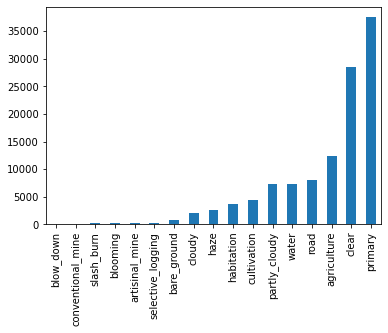

In [18]:
df_target[categories].sum().sort_values().plot.bar()

We see that the dataset is a highly imbalanced dataset with the 'primary' label occurring most frequently, followed by the labels 'clear', 'agriculture' and some other labels such as 'blow_down', 'conventional_mine', 'slash_burn' appearing less frequently.

Lets compute the percentage distribution for each of the labels:

In [31]:
s = df_target[categories].sum()/len(df_target) * 100
s.sort_values(ascending=False)

primary              92.672744
clear                70.236419
agriculture          30.423182
road                 19.938734
water                18.308259
partly_cloudy        17.937696
cultivation          11.060056
habitation            9.041725
haze                  6.662714
cloudy                5.160701
bare_ground           2.129499
selective_logging     0.839942
artisinal_mine        0.837471
blooming              0.820178
slash_burn            0.516317
conventional_mine     0.247042
blow_down             0.242101
dtype: float64

### Image Pre-processing

#### Next, we will use functions from the keras image pre-processing library to convert the jpg images to numpy arrays

* We first use the keras load_img() function to convert the jpg images to PIL (Python Image Library) format with target size 128x128
* We then use the keras image_to_array() function to convert the PIL image instance to numpy array.
* We also create a numpy.array consisting of target labels retreived from the df_target dataframe, corresponding to the images.
* There are 40,479 images to be processed, and we have limited memory(RAM) of about 32GB. 
* In order to not run out of memory during processing we will process the images in batches of 5000

In [20]:
%%time

def load_images(beg, end):
    '''
    INPUT:
    beg (int) : the start index of the range of images to be procesed
    end (int) : the end index of the range of images to be processed
    
    OUTPUT:
    numpy.array : images converted to numpy.array
    numpy.array : numpy.array containing the target labels
    
    Description:
    The function converts the images to numpy array format , and creates numpy array 
    containing the target labels corresponding to the images .
    '''
    X=[]
    Y=[]
    for i in range(beg, end):
        img = load_img(path_prfx + str(i) + '.jpg', target_size=(128,128))
        img_arr = img_to_array(img, dtype='uint8')
        tags = df_target[categories].iloc[i].values
        X.append(img_arr)
        Y.append(tags)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


* Process the images in batches of 5000
* Save the pre-processed images and their corresponding labels to the filesystem in npz format

In [21]:
%%time
total = len(df_target)
size = 5000
end=0
for i in range(total//size):
    beg = end
    end = beg + size
    if i == total//size - 1:
        end = total
    else:
        end = beg + size
    
    X, Y = load_images(beg, end)
    fname = 'data/amazon_forest_part_' + str(i) + '.npz'
    np.savez_compressed(fname, X=X, Y=Y)

CPU times: user 3min 22s, sys: 28.1 s, total: 3min 50s
Wall time: 10min 41s


#### Before proceeding further, lets load the saved npz files to validate that the pre-processed images and their labels can be restored successfully.

* We load the individual npz files, 
* Retrieve the data from these, 
* Stack the data to re-create the numpy arrays corresponding to all the images and the labels.

In [24]:
%%time

import glob
x_list = []
y_list = []
for name in glob.glob('data/amazon_forest_part*npz'):
    amz_imgaes = np.load(name)
    x, y = amz_imgaes['X'], amz_imgaes['Y']
    x_list.append(x)
    y_list.append(y) 

CPU times: user 12.8 s, sys: 347 ms, total: 13.2 s
Wall time: 17.7 s


In [25]:
%%time
x_tup = tuple(x_list)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [26]:
y_tup = tuple(y_list)

In [27]:
%%time
X = np.vstack(x_tup)

CPU times: user 381 ms, sys: 26 µs, total: 382 ms
Wall time: 380 ms


In [28]:
Y = np.vstack(y_tup)

In [29]:
X.shape

(40479, 128, 128, 3)

The X numpy array consists of the 40479 images, each image represented as a 128x128x3 numpy array

In [30]:
Y.shape

(40479, 17)

The Y array contains the labels corresponding to the images

#### Let's plot some data from these arrays and check if the images and the labels get displayed fine.

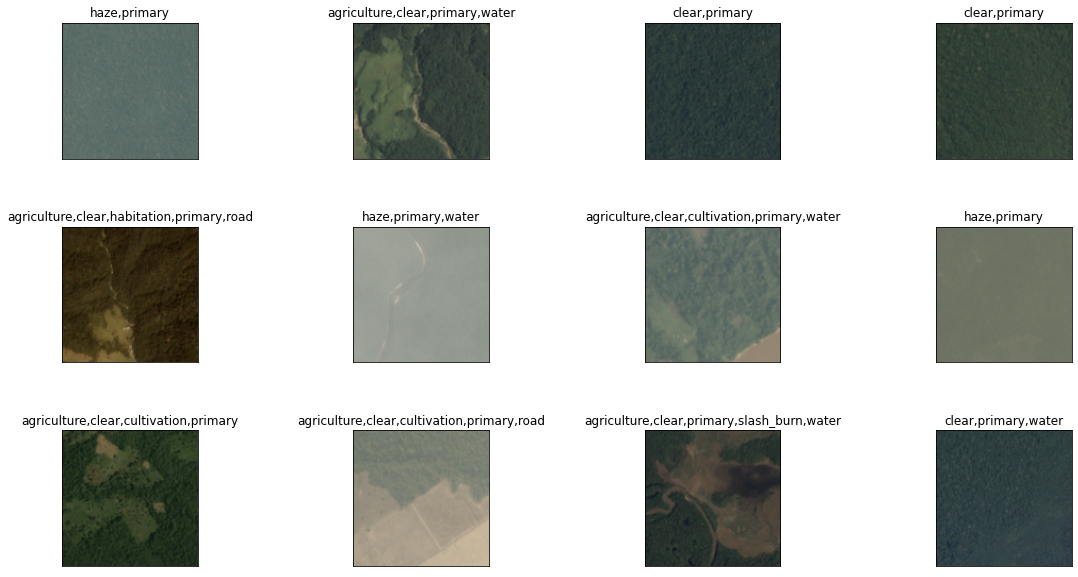

In [31]:
fig = plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.5)
dlim = ','
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X[i]))
    tag_ids = np.where(Y[i] == 1)
    labels = dlim.join([categories[idx] for idx in tag_ids[0]])
    ax.title.set_text(labels)

As we can see, the images and the labels can be retrieved successfully from the saved npz files.

In the [next notebook](./AmazonForest-model-train-V1.ipynb) we will use the pre-processed image data to train a classification model.